In [8]:
# Required libraries

import os
from collections import Counter
import calendar

from scipy import stats 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [9]:
# Preparing the dataset for work

def preparation_dataset(file_name):

    data_frame = pd.read_csv(file_name)
    data_frame.fillna('')

    # remove duplicates
    data_frame.drop_duplicates(inplace=True)

    # remove all empty strings
    data_frame.dropna(how='all', inplace=True)

    # remove all cells without numbers
    mask = ~data_frame[['Height', 'BirthDate']].apply(lambda col: col.astype(str).str.contains(r'\d')).any(axis=1)
    data_frame = data_frame[~mask]

    # remove by time
    start_t = pd.to_datetime('01:00:00').time()
    end_t = pd.to_datetime('03:00:00').time()

    data_frame['BirthDate'] = pd.to_datetime(data_frame['BirthDate'], errors='coerce')
    mask = (data_frame['BirthDate'].notna()) & (data_frame['BirthDate'].dt.time >= start_t) & (data_frame['BirthDate'].dt.time <= end_t)
    
    return data_frame[~mask]


In [10]:
# Get metrics and join

def metrics_calculation(data_frame):

    data_frame['Hour'] = pd.to_datetime(data_frame['BirthDate']).dt.hour

    grouped = data_frame.groupby('Hour')
    result = pd.DataFrame({
        'UniqueCounts': grouped['Name'].nunique(),
        'MeanValues': grouped['Height'].mean(),
        'MedianValues': grouped['Height'].median()
    })
    data_frame = data_frame.join(result, on='Hour', how='left')
    return data_frame


In [11]:
# Vizualization

def get_histogram(data_frame, fig_size):
    '''
    Having a large sample and normal distribution of data, 
    I calculated a confidence interval based on the sample - 
    I used the z-distribution.
    '''
    sample = data_frame['Height']

    # calculate mean and standart deviation
    mean = np.mean(sample)
    std_dev = np.std(sample)
    n = len(sample)

    # calculate of 95% cinfidience interval
    confidience_level = 0.95
    Z = stats.norm.ppf((1 + confidience_level) / 2)

    # formula for confidience level
    margin_of_error = Z * (std_dev / np.sqrt(n))
    confidience_interval = (mean - margin_of_error, mean + margin_of_error)

    plt.figure(figsize=fig_size)
    plt.hist(sample, bins=10, color='skyblue', alpha=0.7, edgecolor='black')
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean:.2f}')
    plt.axvline(confidience_interval[0], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Lower: {confidience_interval[0]:.2f}')
    plt.axvline(confidience_interval[1], color='green', linestyle='dotted', linewidth=2, label=f'95% CI Upper: {confidience_interval[1]:.2f}')
    plt.title('Histogram with 95% Confidence Interval')
    plt.xlabel('Salary')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

def get_graph(data_frame, fig_size):
    data_frame['BirthDate'] = pd.to_datetime(data_frame['BirthDate'])
    data_frame['month'] = data_frame['BirthDate'].dt.month
    monthly_mean = data_frame.groupby('month')['Height'].mean()

    monthly_mean.index = [calendar.month_abbr[int(month)] for month in monthly_mean.index]

    plt.figure(figsize=fig_size)
    plt.plot(monthly_mean.index, monthly_mean.values)
    plt.title('Graph of the average value of the Height column')
    plt.xlabel('Month')
    plt.ylabel('Salary')
    plt.grid(True)
    plt.show()

def get_heatmap(data_frame, fig_size):
    def count_char_frequencies(texts):
        freq = Counter()
        for text in texts:
            if not pd.isna(text):
                freq.update(text)
        return dict(freq)

    frequencies = count_char_frequencies(data_frame['Name'])

    frq_matrix = pd.DataFrame.from_dict(frequencies, orient='index', columns=['Frequency'])
    frq_matrix = frq_matrix.T
    frq_matrix

    plt.figure(figsize=fig_size)
    sns.heatmap(frq_matrix, annot=True, cmap='plasma', linewidths=0.5, annot_kws={'rotation': 90})
    plt.title('Heat map by symbol frequency')
    plt.xlabel('Symbols')
    plt.show()

def parallel_ploting(data_frame, fig_size):

    get_histogram(data_frame, fig_size)
    get_graph(data_frame, fig_size)
    get_heatmap(data_frame, fig_size)


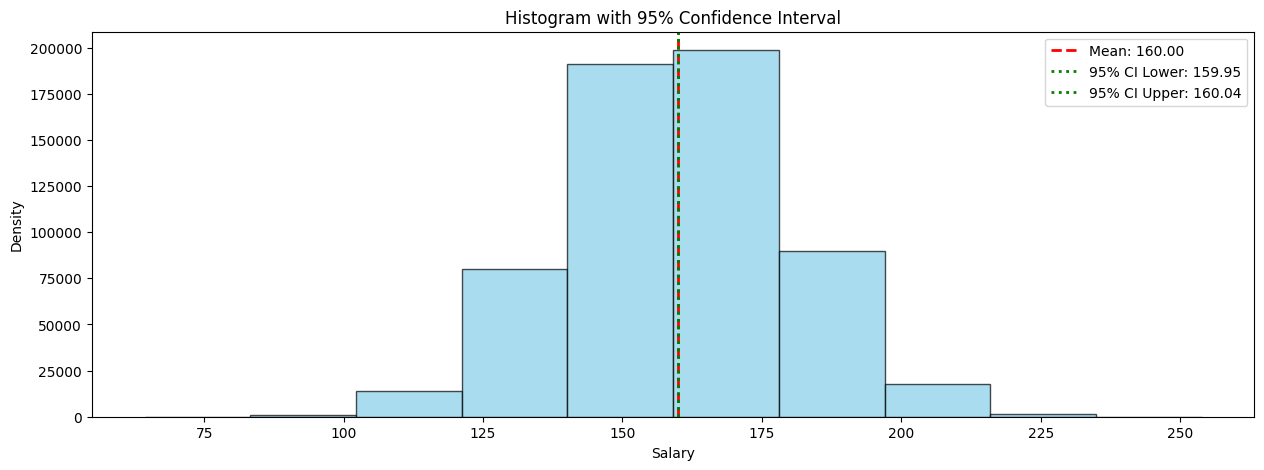

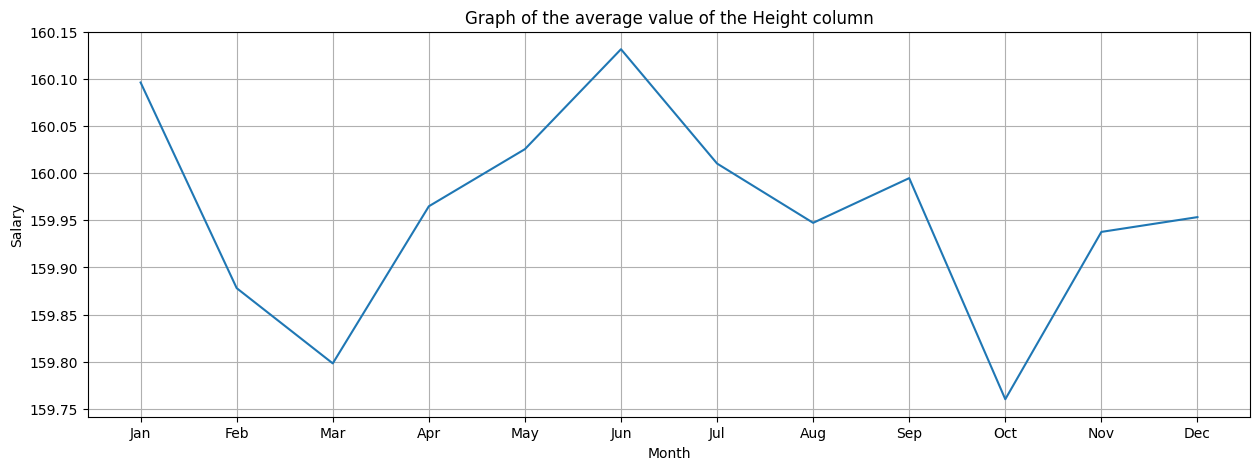

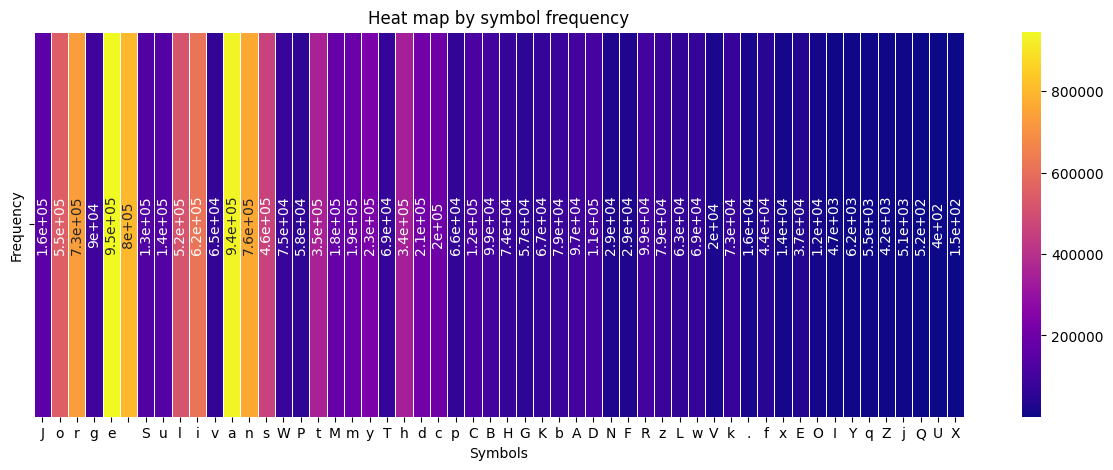

In [ ]:
# Processing

figure_size = (15, 5)
file_name = '.test_data_set_1million.csv'

df = preparation_dataset(file_name)
df = metrics_calculation(df)

parallel_ploting(df, figure_size)

# last results:
# 1 milliom - 10.7s 